# 04_Validation: Model Selection

This notebook compares two clustering models for consul poisoning detection:
- **HDBSCAN**: Density-based clustering approach
- **GMM**: Gaussian Mixture Model probabilistic approach  
- **Isolation Forest**: Anomaly detection approach

## Imports

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import hdbscan
import umap
import joblib  
import plotly.express as px
from sklearn.metrics import (
    homogeneity_score,
    completeness_score,
    v_measure_score,
    silhouette_score,
    silhouette_samples,precision_recall_curve, auc
)
from plotly.subplots import make_subplots


## Load data

In [92]:
hdb = joblib.load('../models/hdbscan_model.joblib')
gmm = joblib.load('../models/gmm_model.joblib')
isof = joblib.load('../models/isolation_forest_model.joblib')
df = pd.read_csv('../data/processed/windowed_dataset_cleaned.csv')
X = df[df.columns.difference(['is_attack'])]
y = df['is_attack']

## Evaluation metrics : HDBSCAN

### External index

In [93]:
hdb_labels = hdb.fit_predict(X)

# Usar hdb.labels_ o hdb_labels (son equivalentes tras fit_predict)
mask = hdb_labels != -1  # o: mask = hdb.labels_ != -1

X_clustered = X[mask]
labels_clustered = hdb_labels[mask]  # o: hdb.labels_[mask]
y_clustered = y[mask]

metrics = {}

# Métricas externas
metrics["Homogeneity"] = homogeneity_score(y_clustered, labels_clustered)
metrics["Completeness"] = completeness_score(y_clustered, labels_clustered)
metrics["V-measure"] = v_measure_score(y_clustered, labels_clustered)

These metrics are calculated using labels.

### Internal Index : Silhouette Scores

In [94]:
metrics["Silhouette"] = silhouette_score(
    X_clustered,
    labels_clustered,
    metric='euclidean'
)
hdb_metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['score'])


This metric will say how close the samples are to their own cluster comparing to the closest cluster.

In [95]:
silhouette_vals = silhouette_samples(X_clustered, labels_clustered)
mean_sil = silhouette_score(X_clustered, labels_clustered, metric='euclidean')
n_noise = (hdb_labels == -1).sum()
pct_noise = n_noise / len(hdb_labels) * 100

print(f"Note: HDBSCAN detected {n_noise} noise points ({pct_noise:.1f}%)")

# 3. Preparar trazas por cluster
unique_labels = np.unique(labels_clustered)
y_lower = 0
traces = []
MAX_POINTS_PER_CLUSTER = 2000  # límite visual para rendimiento

for label in unique_labels:
    cluster_mask = (labels_clustered == label)
    cluster_sil_vals = silhouette_vals[cluster_mask]
    n_points = len(cluster_sil_vals)
    
    # Ordenar valores
    sorted_vals = np.sort(cluster_sil_vals)
    
    # Submuestrear solo para visualización si es muy grande
    if n_points > MAX_POINTS_PER_CLUSTER:
        step = max(1, n_points // MAX_POINTS_PER_CLUSTER)
        plot_vals = sorted_vals[::step]
    else:
        plot_vals = sorted_vals
    
    y_upper = y_lower + len(plot_vals)
    y_range = np.arange(y_lower, y_upper)
    
    traces.append(go.Scatter(
        x=plot_vals,
        y=y_range,
        mode='lines',
        fill='tozerox',
        fillcolor=f'rgba({np.random.randint(50,200)}, {np.random.randint(50,200)}, {np.random.randint(50,200)}, 0.6)',
        line=dict(width=0),
        name=f"Cluster {label} (n={n_points})",
        hovertemplate=(
            f"<b>Cluster {label}</b><br>" +
            "Silhouette: %{x:.3f}<br>" +
            f"Total points: {n_points}<extra></extra>"
        )
    ))
    
    y_lower = y_upper + 10  # espacio entre clusters

# 4. Crear figura
fig = go.Figure()

# Añadir clusters
for trace in traces:
    fig.add_trace(trace)

# Línea de silueta promedio
fig.add_vline(
    x=mean_sil,
    line=dict(color="red", dash="dash", width=2),
    annotation_text=f"Mean = {mean_sil:.3f}",
    annotation_position="top right"
)

# Diseño
fig.update_layout(
    title=f"HDBSCAN: Silhouette Plot (excluding {n_noise} noise points)",
    xaxis_title="Silhouette Coefficient",
    yaxis_title="Sample Index (grouped by cluster)",
    height=700,
    width=900,
    hovermode="closest",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5,
        font=dict(size=10)
    ),
    plot_bgcolor="white"
)

fig.update_xaxes(range=[-0.1, 1.0])
fig.update_yaxes(showticklabels=False)  # los índices no son significativos

fig.show()

Note: HDBSCAN detected 1441 noise points (6.0%)


- As we can see here the silhouette score is very high, which means that the majority of the samples are well clustered, at least close to their cluster. For the cluster 2 we can see very few points with a bad clustering. 
- the size of the cluster 0 is very big so it might look like the silhouette average score is very good but it is mostly good for that specific cluster.
- It is not enough to say that the data is well clustered.

### Every metric

In [96]:
# Visualize HDBSCAN metrics
metrics_display = hdb_metrics_df.reset_index()
fig = px.bar(
    metrics_display,
    x='index',
    y='score',
    title='HDBSCAN: Classification & Clustering Metrics',
    text='score'
)

fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_layout(
    yaxis_range=[0, 1],
    xaxis_title="Metric",
    yaxis_title="Score",
    showlegend=False
)
fig.show()


- High Homogeneity: Clusters are very pure, most points within each cluster belong to the same ground-truth class. This suggests HDBSCAN effectively separates classes.
- Low Completeness: Many points from the same ground-truth class are scattered across multiple clusters. This indicates HDBSCAN is not finding accurately true classes.
- Moderate/Low V-measure: A balanced metric combining homogeneity and completeness. The low score reflects the trade-off — high purity but poor grouping.
- High Silhouette Score: Points are well-clustered internally and clearly separated from other clusters.

### Semisupervised evaluation

In [97]:
cm_df = pd.crosstab(y, hdb_labels, rownames=['is_attack'], colnames=['gmm_label'])

# Extract data
z = cm_df.values
x = [f"Cluster {col}" for col in cm_df.columns]  # e.g., ["Cluster 0", "Cluster 1", ...]
y_labels = ["Normal (0)", "Attack (1)"]           # Row labels

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=z,
    x=x,
    y=y_labels,
    colorscale='Blues',
    text=z,
    texttemplate="%{text}",
    textfont={"size": 16},
    hovertemplate=(
        "<b>True Class:</b> %{y}<br>" +
        "<b>Predicted Cluster:</b> %{x}<br>" +
        "<b>Count:</b> %{z}<extra></extra>"
    ),
    colorbar=dict(title="Sample Count")
))

# Update layout
fig.update_layout(
    title={
        'text': "HDBSCAN Confusion Matrix: True Attack Labels vs Predicted Clusters",
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18}
    },
    xaxis_title="Predicted HDBSCAN Cluster",
    yaxis_title="True Label (is_attack)",
    width=700,
    height=500,
    font=dict(size=14)
)

fig.show()

- As said, the model is not able to make a cluster with the attacks, nor isolate them as outliers. We could say that it has a doubt whether the attacks form a cluster themselves of are outliers.

## Evaluation metrics: GMM

### External Index

In [98]:
gmm_labels = gmm.fit_predict(X)

# Usar hdb.labels_ o hdb_labels (son equivalentes tras fit_predict)
mask = gmm_labels != -1  # o: mask = hdb.labels_ != -1

X_clustered = X[mask]
labels_clustered = gmm_labels[mask]  # o: hdb.labels_[mask]
y_clustered = y[mask]

metrics = {}

# Métricas externas
metrics["Homogeneity"] = homogeneity_score(y_clustered, labels_clustered)
metrics["Completeness"] = completeness_score(y_clustered, labels_clustered)
metrics["V-measure"] = v_measure_score(y_clustered, labels_clustered)

### Internal Index

In [99]:
metrics["Silhouette"] = silhouette_score(
    X_clustered,
    labels_clustered,
    metric='euclidean'
)
gmm_metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['score'])


These metrics are calculated using labels. 

In [100]:
silhouette_vals = silhouette_samples(X_clustered, labels_clustered)
mean_silhouette = np.mean(silhouette_vals)  # o usa metrics["Silhouette"] si ya lo tienes

# Preparar datos por cluster
unique_labels = np.unique(labels_clustered)
y_lower = 0
traces = []

# Máximo número de puntos a mostrar por cluster (solo para rendimiento visual)
MAX_POINTS_PER_CLUSTER = 3000

for label in unique_labels:
    # Seleccionar valores del cluster
    cluster_mask = (labels_clustered == label)
    cluster_sil_vals = silhouette_vals[cluster_mask]
    n_points = len(cluster_sil_vals)
    
    # Ordenar
    sorted_vals = np.sort(cluster_sil_vals)
    
    # Submuestrear solo para visualización si es muy grande
    if n_points > MAX_POINTS_PER_CLUSTER:
        step = n_points // MAX_POINTS_PER_CLUSTER
        plot_vals = sorted_vals[::step]
    else:
        plot_vals = sorted_vals
    
    y_upper = y_lower + len(plot_vals)
    y_range = np.arange(y_lower, y_upper)
    
    # Crear trace con hover personalizado
    traces.append(go.Scatter(
        x=plot_vals,
        y=y_range,
        mode='lines',
        fill='tozerox',
        fillcolor=f'rgba({np.random.randint(50,200)}, {np.random.randint(50,200)}, {np.random.randint(50,200)}, 0.6)',
        line=dict(width=0),
        name=f"Cluster {label} (n={n_points})",
        hovertemplate=(
            f"<b>Cluster {label}</b><br>" +
            "Silhouette: %{x:.3f}<br>" +
            "Posición: %{y}<br>" +
            f"Tamaño total: {n_points}<extra></extra>"
        ),
        showlegend=True
    ))
    
    y_lower = y_upper + 10  # espacio entre clusters

# Crear figura
fig = go.Figure()

# Añadir todos los clusters
for trace in traces:
    fig.add_trace(trace)

# Línea de silueta promedio
fig.add_vline(
    x=mean_silhouette,
    line=dict(color="red", dash="dash", width=2),
    annotation_text=f"Mean = {mean_silhouette:.3f}",
    annotation_position="top right"
)

# Diseño
fig.update_layout(
    title="Silhouette Plot (GMM)",
    xaxis_title="Silhouette Coefficient",
    yaxis_title="Sample Index (grouped by cluster)",
    height=700,
    width=900,
    hovermode="closest",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    plot_bgcolor="white"
)

fig.update_xaxes(range=[-0.1, 1.0])
fig.update_yaxes(showticklabels=False)  # los índices no son significativos

fig.show()

- We also see 3 clusters here, which have a higher number of samples poorly clustered. On th left, we can see many negative silhouette score samples which mean that they are closer to the closest cluster than to their own cluster. This suggests poor clustering.
- The average Silhouette Score is still high as most samples are correctly clustered in the cluster 0. Like in the previous model, we should take that much into account this average silhouette value.

### Every Metric

In [101]:
# Visualize GMM metrics
metrics_display = gmm_metrics_df.reset_index()
fig = px.bar(
    metrics_display,
    x='index',
    y='score',
    title='GMM: Classification & Clustering Metrics',
    text='score'
)

fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_layout(
    yaxis_range=[0, 1],
    xaxis_title="Metric",
    yaxis_title="Score",
    showlegend=False
)
fig.show()


- High Homogeneity: Clusters are very pure, most points within each cluster belong to the same ground-truth class. 
- Low Completeness: Many points from the same ground-truth class are scattered across multiple clusters. This indicates GMM is not accurately distinguishing both classes
- High Silhouette Score: Even if the score is high it is influenced by the big cluster 0. In reality, many samples are poorly clustered.

### Semisupervised evaluation

In [102]:
cm_df = pd.crosstab(y, gmm_labels, rownames=['is_attack'], colnames=['gmm_label'])

# Extract data
z = cm_df.values
x = [f"Cluster {col}" for col in cm_df.columns]  # e.g., ["Cluster 0", "Cluster 1", ...]
y_labels = ["Normal (0)", "Attack (1)"]           # Row labels

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=z,
    x=x,
    y=y_labels,
    colorscale='Blues',
    text=z,
    texttemplate="%{text}",
    textfont={"size": 16},
    hovertemplate=(
        "<b>True Class:</b> %{y}<br>" +
        "<b>Predicted Cluster:</b> %{x}<br>" +
        "<b>Count:</b> %{z}<extra></extra>"
    ),
    colorbar=dict(title="Sample Count")
))

# Update layout
fig.update_layout(
    title={
        'text': "GMM Confusion Matrix: True Attack Labels vs Predicted Clusters",
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18}
    },
    xaxis_title="Predicted GMM Cluster",
    yaxis_title="True Label (is_attack)",
    width=700,
    height=500,
    font=dict(size=14)
)

fig.show()

- The model is able to **detect every attack** and cluster them together but is **unable to make a clear separation** with some legitimate network traffic. As we have seen, the self-registries.

## Evaluation Metrics: Isolation Forest

ROC AUC: 0.9998
Average Precision (PR AUC): 0.9923


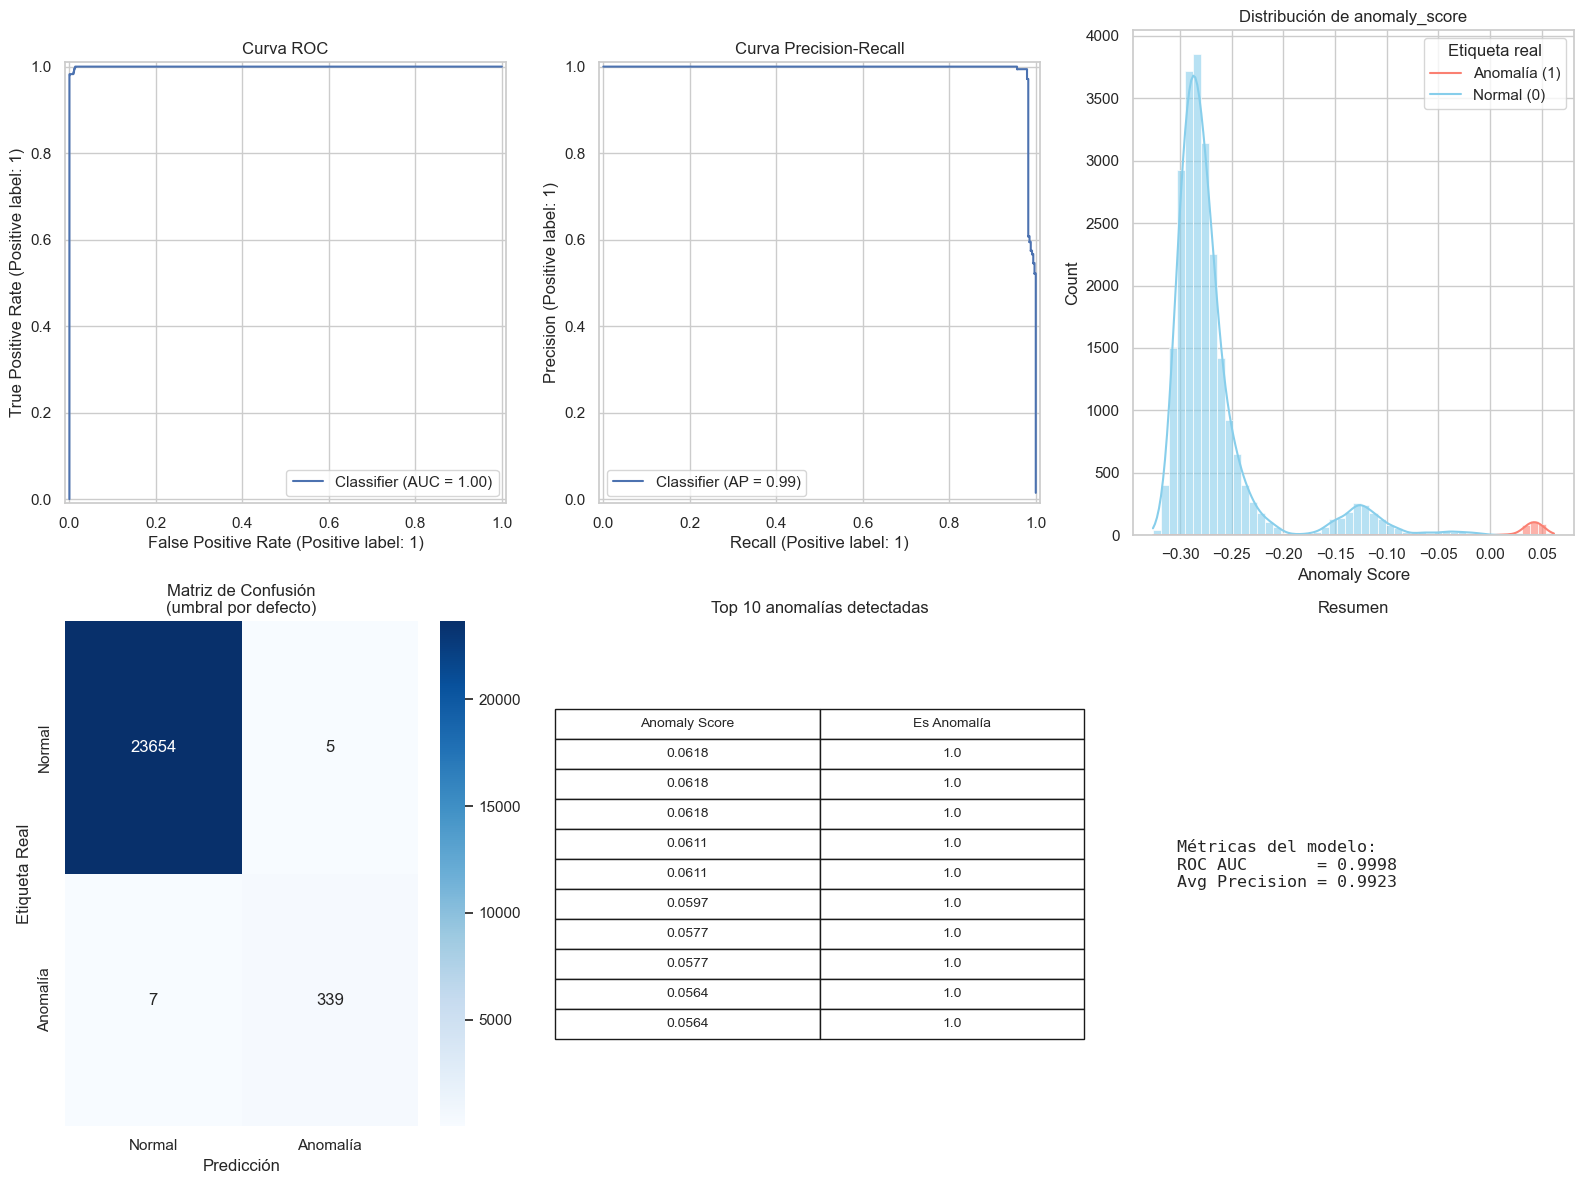

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    confusion_matrix
)
import numpy as np

isof_labels = isof.predict(X)
df['anomaly_score'] = -isof.decision_function(X)  # Invertir para que valores altos indiquen anomalías
df['anomaly_label'] = (isof_labels == -1).astype(int)  # 1 = anomalía, 0 = normal

# --- Métricas ---
auc_roc = roc_auc_score(y, df['anomaly_score'])
auc_pr = average_precision_score(y, df['anomaly_score'])
print(f"ROC AUC: {auc_roc:.4f}")
print(f"Average Precision (PR AUC): {auc_pr:.4f}")

# --- Configuración de estilo ---
sns.set(style="whitegrid")
fig = plt.figure(figsize=(16, 12))

# 1. Curva ROC
ax1 = plt.subplot(2, 3, 1)
RocCurveDisplay.from_predictions(y, df['anomaly_score'], ax=ax1)
ax1.set_title('Curva ROC')

# 2. Curva Precision-Recall
ax2 = plt.subplot(2, 3, 2)
PrecisionRecallDisplay.from_predictions(y, df['anomaly_score'], ax=ax2)
ax2.set_title('Curva Precision-Recall')

# 3. Distribución del anomaly_score por clase real
ax3 = plt.subplot(2, 3, 3)
sns.histplot(
    x=df['anomaly_score'],
    hue=y,
    bins=50,
    kde=True,
    alpha=0.6,
    palette=['skyblue', 'salmon'],
    ax=ax3
)
ax3.set_title('Distribución de anomaly_score')
ax3.set_xlabel('Anomaly Score')
ax3.legend(title='Etiqueta real', labels=['Anomalía (1)','Normal (0)'])

# 4. Matriz de confusión
ax4 = plt.subplot(2, 3, 4)
cm = confusion_matrix(y, df['anomaly_label'])
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Normal', 'Anomalía'],
    yticklabels=['Normal', 'Anomalía'],
    ax=ax4
)
ax4.set_title('Matriz de Confusión\n(umbral por defecto)')
ax4.set_ylabel('Etiqueta Real')
ax4.set_xlabel('Predicción')

# 5. Top 10 anomalías (tabla simple como texto en gráfico)
ax5 = plt.subplot(2, 3, 5)
top10 = df.nlargest(10, 'anomaly_score')[['anomaly_score', 'anomaly_label']]
ax5.axis('tight')
ax5.axis('off')
table = ax5.table(
    cellText=top10.round(4).values,
    colLabels=['Anomaly Score', 'Es Anomalía'],
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
ax5.set_title('Top 10 anomalías detectadas')

# 6. Estadísticas resumen (texto)
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
stats_text = f"""Métricas del modelo:
ROC AUC       = {auc_roc:.4f}
Avg Precision = {auc_pr:.4f}
"""
ax6.text(0.1, 0.5, stats_text, fontsize=12, verticalalignment='center', family='monospace')
ax6.set_title('Resumen')

# Ajustar layout y mostrar
plt.tight_layout()
plt.show()

- Isolation forest is an outlier detector model. It assigns an anomaly score to each sample, it does not cluster them. We have to define where to put the threshold for it to consider as an outlier or not.
- As we can see from the conussion matrix, the model performs very well when classifying the data. Most of the attacks are well classified as anomalies. The precision-recall curve shows that even in this inbalanced problem, the model is able to understand the data correctly and find the attacks within the network traffic.

## Model Comparison

### Clustering comparison

In [104]:
# Create comparison dataframe for HDBSCAN vs GMM
comparison_data = {
    'HDBSCAN': hdb_metrics_df['score'],
    'GMM': gmm_metrics_df['score']
}

comparison_df = pd.DataFrame(comparison_data)
print("\n=== HDBSCAN vs GMM COMPARISON ===\n")
print(comparison_df.round(3))

# Highlight best scores for each metric
print("\n=== BEST PERFORMER BY METRIC ===\n")
for metric in comparison_df.index:
    best_model = comparison_df.loc[metric].idxmax()
    best_score = comparison_df.loc[metric].max()
    print(f"{metric:20s}: {best_model:20s} ({best_score:.3f})")


=== HDBSCAN vs GMM COMPARISON ===

              HDBSCAN    GMM
Homogeneity     0.900  0.781
Completeness    0.213  0.168
V-measure       0.344  0.277
Silhouette      0.988  0.919

=== BEST PERFORMER BY METRIC ===

Homogeneity         : HDBSCAN              (0.900)
Completeness        : HDBSCAN              (0.213)
V-measure           : HDBSCAN              (0.344)
Silhouette          : HDBSCAN              (0.988)


In [105]:
# Visual comparison of all metrics between HDBSCAN and GMM
fig = go.Figure()

for model in comparison_df.columns:
    fig.add_trace(go.Bar(
        name=model,
        x=comparison_df.index,
        y=comparison_df[model],
        text=comparison_df[model].round(3),
        textposition='outside'
    ))

fig.update_layout(
    title='HDBSCAN vs GMM: Clustering Metrics Comparison',
    xaxis_title='Metric',
    yaxis_title='Score',
    yaxis_range=[0, 1.1],
    barmode='group',
    hovermode='x unified'
)
fig.show()

print("\n Interpretation:")
print("  • Homogeneity: How many samples from same attack group are in same cluster")
print("  • Completeness: How many samples from same attack group are in one cluster")
print("  • V-measure: Harmonic mean of homogeneity and completeness")
print("  • Silhouette: Measure of cluster cohesion and separation")


 Interpretation:
  • Homogeneity: How many samples from same attack group are in same cluster
  • Completeness: How many samples from same attack group are in one cluster
  • V-measure: Harmonic mean of homogeneity and completeness
  • Silhouette: Measure of cluster cohesion and separation


- HDBSCAN is superior to GMM in unsupervised metrics, internal and external, when it comes to the clustering task.

### Semisupervised Comparison

In [106]:
# Semi-Supervised Anomaly Detection Metrics Comparison

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Treat cluster -1 (noise) as anomalies for HDBSCAN
hdb_anomaly = ((hdb_labels == -1) | (hdb_labels == 0)).astype(int)
# Treat clusters 2 as anomalies for GMM (non-dominant clusters)
gmm_anomaly = (gmm_labels == 2).astype(int)

# Calculate metrics
models = ['HDBSCAN', 'GMM', 'Isolation Forest']
anomaly_preds = [hdb_anomaly, gmm_anomaly, df['anomaly_label']]

hdb_scores = hdb.probabilities_ if hasattr(hdb, 'probabilities_') else -hdb.outlier_scores_

# GMM: usar log-likelihood negativa como score
gmm_scores = -gmm.score_samples(X)

# Isolation Forest: ya tenemos anomaly_score
isof_scores = df['anomaly_score'].values

anomaly_scores = [hdb_scores, gmm_scores, isof_scores]

results = []
for model, preds in zip(models, anomaly_preds):
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)
    f1 = f1_score(y, preds)
    accuracy = accuracy_score(y, preds)
    
    results.append({
        'Model': model,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import precision_recall_curve, auc

# ... [Your existing subplot code for metrics bar plot + PR curves] ...

# ==================== FIXED TABLE VISUALIZATION ====================
# Extract model names from DataFrame INDEX (not columns)
models_list = comparison_df.index.tolist()  # e.g., ['HDBSCAN', 'GMM']

fig_table = go.Figure(data=[go.Table(
    header=dict(
        values=['<b>Model</b>', '<b>Precision</b>', '<b>Recall</b>', '<b>F1-Score</b>'],
        fill_color='#3498db',
        align='center',
        font=dict(color='white', size=13)
    ),
    cells=dict(
        values=[
            models_list,  # Model names from index
            [f"{x:.4f}" for x in comparison_df['Precision']],
            [f"{x:.4f}" for x in comparison_df['Recall']],
            [f"{x:.4f}" for x in comparison_df['F1-Score']]  # Fixed: removed list literal
        ],
        fill_color='#ecf0f1',
        align='center',
        font=dict(size=12),
        height=30
    )
)])

fig_table.update_layout(
    title_text="<b>Detailed Metrics Comparison</b>",
    title_x=0.5,
    title_font_size=18,
    width=900,
    height=300
)

fig_table.show()

# ==================== FIXED BAR CHART ====================
# Create new figure for clustering metrics (Homogeneity, V-measure, etc.)
clustering_metrics = ['Homogeneity', 'Completeness', 'V-measure', 'Silhouette']

fig_clustering = go.Figure()
for model in comparison_df.index:  # Iterate over index (model names)
    fig_clustering.add_trace(go.Bar(
        name=model,
        x=clustering_metrics,
        y=[comparison_df.loc[model, metric] for metric in clustering_metrics],
        text=[f"{comparison_df.loc[model, metric]:.3f}" for metric in clustering_metrics],
        textposition='outside'
    ))

fig_clustering.update_layout(
    title='HDBSCAN vs GMM: Clustering Metrics Comparison',
    xaxis_title='Metric',
    yaxis_title='Score',
    yaxis_range=[0, 1.1],
    barmode='group',
    hovermode='x unified',
    height=500
)
fig_clustering.show()

print("\nInterpretation:")
print("  • Homogeneity: How many samples from same attack group are in same cluster")
print("  • Completeness: How many samples from same attack group are in one cluster")
print("  • V-measure: Harmonic mean of homogeneity and completeness")
print("  • Silhouette: Measure of cluster cohesion and separation")

KeyError: 'Model'

- When it comes to finding the attacks which is the objective of this work, **GMM surpasses HDBSCAN** precision and f1-score. Both models have a 100% recall which means that they are **able to detect** every single attack but the are **not able to differenciate** them from normal network traffic. That is why both have very poor precision recall curves.

- In the other hand, Isolation Forest,is extremely **precise at detecting and separating** the attacks from network traffic as its recall and precision are around **98,5%**

# Final Conclusion

GMM/HDBSCAN → Exploratory Analysis ✓
These two serve a great purpose understanding the difficulties of the task and the underlying reasons why the attacks are not that easy to detect.

Isolation Forest → Production Security System ✓
This model is the one chosen for production as his nature fits better the task of attack detection.